In [76]:
import findspark
findspark.init()

In [77]:
from pyspark.sql import SparkSession

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

### Read data

In [78]:
def load_raw_data(path):
    df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
    return df

# Loading data from the source path
raw_df = load_raw_data("/dataset/nyc-jobs.csv")

# Displaying first 5 rows
raw_df.show(5, truncate=False)

+------+----------------------------+------------+--------------+----------------------------------------------------+------------------------------+-------------+-----+------------------------+-----------------------------+-----------------+---------------+----------------+----------------------------+------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

1. Data Cleaning and Cast coulmns

In [79]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, to_date
def clean_and_cast(df):
    return df \
        .withColumn("# Of Positions", col("# Of Positions").cast("int")) \
        .withColumnRenamed("# Of Positions","No of Positions") \
        .withColumn("Salary Range From", col("Salary Range From").cast("double")) \
        .withColumn("Salary Range To", col("Salary Range To").cast("double")) \
        .withColumn("Posting Date", to_date("Posting Date")) \
        .withColumn("Post Until", to_date("Post Until")) \
        .withColumn("Posting Updated", to_date("Posting Updated")) \
        .withColumn("Process Date", to_date("Process Date")) \
        .withColumn("Average Salary", ((col("Salary Range From") + col("Salary Range To")) / 2)) \
        .filter(col("Job ID").isNotNull()) \
        .filter(col("Job Category").isNotNull())
cleaned_df = clean_and_cast(raw_df)
cleaned_df.show(5)


+------+--------------------+------------+---------------+--------------------+-------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+------------+----------+---------------+------------+--------------+
|Job ID|              Agency|Posting Type|No of Positions|      Business Title|Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift|     Work Location 1| Recruitment Contact|Residency Requirement|Posting Dat

2. Feature Engineering (3 techniques)

In [80]:
from pyspark.sql.functions import year,desc,when,lower

def apply_feature_engineering(df):
    # 1. Extract Year from Posting Date
    df = df.withColumn("Posting Year", year("Posting Date"))

    # 2. Job Category Binning 
    top_categories = df.groupBy("Job Category").count().orderBy(desc("count")).limit(10)
    top_cats = [row["Job Category"] for row in top_categories.collect()]
    df = df.withColumn("Job Category Grouped", when(col("Job Category").isin(top_cats), col("Job Category")).otherwise("Other"))

    # 3. Degree Flag
    df = df.withColumn("Requires Degree", when(lower(col("Minimum Qual Requirements")).rlike("bachelor|master|degree"), 1).otherwise(0))

    return df

featured_df = apply_feature_engineering(cleaned_df)
featured_df.select("Job ID", "Job Category", "Job Category Grouped", "Minimum Qual Requirements", "Requires Degree", "Posting Year").show(5, truncate=False)

+------+----------------------------------+----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

3.Features Removal

In [81]:
def drop_columns(df):
    drop_cols = ["To Apply", "Additional Information", "Job Description", 
                 "Residency Requirement", "Recruitment Contact"]
    return df.drop(*drop_cols)

# Applying to previos transformed DataFrame
final_df = drop_columns(featured_df)

# Shows a sample of the cleaned data
final_df.show(5, truncate=False)

+------+-----------------------------+------------+---------------+----------------------------------------------------+-------------------+-------------+-----+----------------------------------+-----------------------------+-----------------+---------------+----------------+----------------------------+------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

4. Storing processed data into a target file

In [82]:
def write_processed_data(df, output_path):
    df.write.mode("overwrite").option("header", "true").csv(output_path)

output_path = "/dataset/nyc-jobs-processed"
write_processed_data(final_df, output_path)

# Read back the saved data
processed_df = spark.read.option("header", "true").csv(output_path)

# Show sample output
processed_df.show(5, truncate=False)

+------+---------------------------+------------+---------------+---------------------------------+------------------------------+-------------+-----+---------------------------------------------------------+-----------------------------+-----------------+---------------+----------------+---------------+-----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Executing Full Processing 

In [83]:
def run_pipeline(input_path, output_path):
    df_raw = load_raw_data(input_path)
    df_clean = clean_and_cast(df_raw)
    df_fe = apply_feature_engineering(df_clean)
    df_final = drop_columns(df_fe)
    write_processed_data(df_final, output_path)
    return df_final

input_path = "/dataset/nyc-jobs.csv"               
output_path = "/dataset/nyc-jobs-processed" 

processed_df = run_pipeline(input_path, output_path)
processed_df.show(5, truncate=False)

+------+-----------------------------+------------+---------------+----------------------------------------------------+-------------------+-------------+-----+----------------------------------+-----------------------------+-----------------+---------------+----------------+----------------------------+------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## KPI and Visualization

1. Whats the number of jobs posting per category (Top 10)

+-----------------------------------------+-----+
|Job Category Grouped                     |count|
+-----------------------------------------+-----+
|Other                                    |857  |
|Engineering, Architecture, & Planning    |504  |
|Technology, Data & Innovation            |313  |
|Legal Affairs                            |226  |
|Public Safety, Inspections, & Enforcement|182  |
|Building Operations & Maintenance        |181  |
|Finance, Accounting, & Procurement       |169  |
|Administration & Human Resources         |134  |
|Constituent Services & Community Programs|129  |
|Health                                   |125  |
+-----------------------------------------+-----+



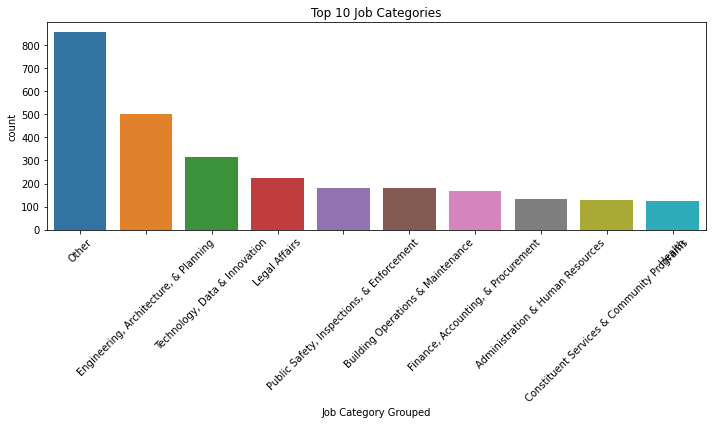

In [84]:
job_postings_by_category = processed_df.groupBy("Job Category Grouped").count().orderBy(desc("count")).limit(10)
job_postings_by_category.show(truncate=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Example: Visualize top 10 job categories
top_categories_pd = job_postings_by_category.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(data=top_categories_pd, x='Job Category Grouped', y='count')
plt.xticks(rotation=45)
plt.title("Top 10 Job Categories")
plt.tight_layout()
plt.show()

2. Whats the salary distribution per job category

+-----------------------------------------+------------------+----------+----------+
|Job Category Grouped                     |Avg Salary        |Min Salary|Max Salary|
+-----------------------------------------+------------------+----------+----------+
|Technology, Data & Innovation            |88066.27343498402 |15.845    |169011.0  |
|Engineering, Architecture, & Planning    |84531.01549603174 |45.49     |151795.0  |
|Legal Affairs                            |83247.09196106195 |21.4116   |191913.0  |
|Finance, Accounting, & Procurement       |73795.10071893492 |17.7      |167500.0  |
|Other                                    |73700.2887259043  |9.555     |218587.0  |
|Policy, Research & Analysis              |63577.708637096766|15.7      |162051.0  |
|Public Safety, Inspections, & Enforcement|62160.95747197802 |15.45     |140659.0  |
|Health                                   |58466.322832399994|16.2816   |170133.84 |
|Constituent Services & Community Programs|57877.57780387597 |17.

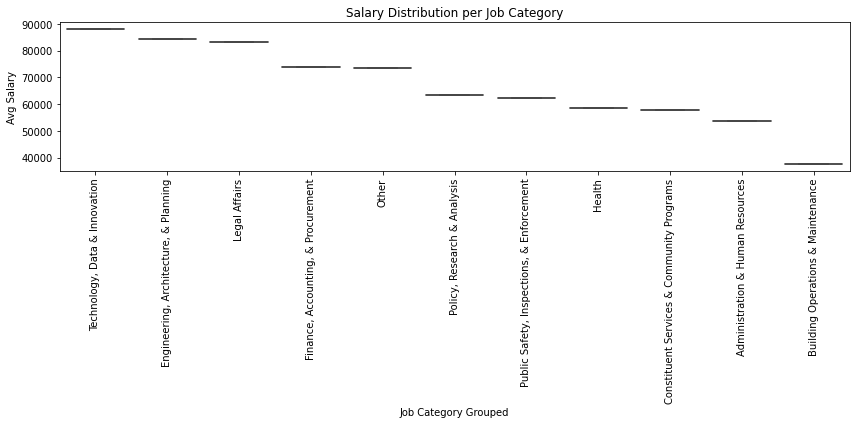

In [85]:
from pyspark.sql.functions import avg, min, max, desc
salary_dist = processed_df.groupBy("Job Category Grouped") \
    .agg(avg("Average Salary").alias("Avg Salary"), min("Average Salary").alias("Min Salary"), max("Average Salary").alias("Max Salary")) \
    .orderBy(desc("Avg Salary"))
salary_dist.show(truncate=False)

salary_pd = salary_dist.select("Job Category Grouped", "Avg Salary").dropna().toPandas()
plt.figure(figsize=(12, 6))
sns.boxplot(data=salary_pd, x="Job Category Grouped", y="Avg Salary")
plt.xticks(rotation=90)
plt.title("Salary Distribution per Job Category")
plt.tight_layout()
plt.show()

3. Is there any correlation between the higher degree and the salary

In [86]:
corr = processed_df.select("Requires Degree", "Average Salary") \
             .stat.corr("Requires Degree", "Average Salary")
print("Correlation between 'Requires Degree' and 'Average Salary':", corr)


Correlation between 'Requires Degree' and 'Average Salary': 0.2579735078707205


4. Whats the job posting having the highest salary per agency

+------------------------------+------------------------------------------------------------+--------------+-----------------------------------------+
|Agency                        |Business Title                                              |Average Salary|Job Category Grouped                     |
+------------------------------+------------------------------------------------------------+--------------+-----------------------------------------+
|LANDMARKS PRESERVATION COMM   |LANDMARKS PRESERVATIONIST, PRESERVATION DEPT                |60103.5       |Engineering, Architecture, & Planning    |
|OFFICE OF COLLECTIVE BARGAININ|COLLEGE AIDE - CLERICAL                                     |9.555         |Other                                    |
|FIRE DEPARTMENT               |Senior Enterprise Applications Integration Developer        |120474.5      |Technology, Data & Innovation            |
|ADMIN FOR CHILDREN'S SVCS     |Assistant Commissioner                                      |1

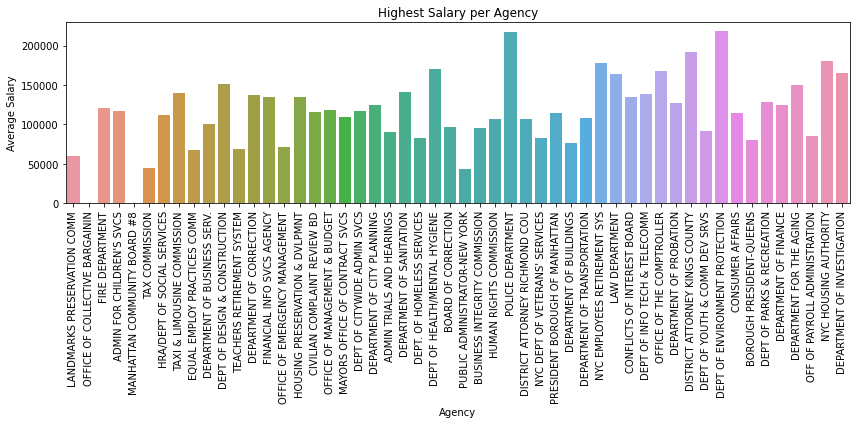

In [87]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
windowSpec = Window.partitionBy("Agency").orderBy(desc("Average Salary"))
top_salary_per_agency = processed_df.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") == 1).drop("rank").\
select("Agency", "Business Title", "Average Salary", "Job Category Grouped")
top_salary_per_agency.show(truncate=False)

agency_salary_pd = top_salary_per_agency.select("Agency", "Business Title", "Average Salary").toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=agency_salary_pd, x="Agency", y="Average Salary")
plt.xticks(rotation=90)
plt.title("Highest Salary per Agency")
plt.tight_layout()
plt.show()

5. Whats the job positings average salary per agency for the last 2 years

In [88]:
from pyspark.sql.functions import current_date, datediff,avg

recent_df = processed_df.filter(year("Posting Date") >= year(current_date()) - 2)
avg_salary_last_2yrs_df = recent_df.groupBy("Agency").agg(avg("Average Salary").alias("Avg Salary")).orderBy(desc("Avg Salary"))
avg_salary_last_2yrs_df.show()


+------+----------+
|Agency|Avg Salary|
+------+----------+
+------+----------+



6. What are the highest paid skills in the US market

+------------------+------------------+
|skill             |Avg Salary        |
+------------------+------------------+
|docker            |137581.5          |
|gcp               |115000.0          |
|aws               |107240.33333333333|
|azure             |106251.11111111111|
|cloud             |99955.5303030303  |
|leadership        |97958.75          |
|java              |93204.33333333333 |
|sql               |91280.99317647058 |
|project management|89846.84179775282 |
|kubernetes        |83250.0           |
|etl               |82876.0           |
|tableau           |82570.73          |
|power bi          |81970.625         |
|python            |79296.75757575757 |
|analytics         |78927.11111111111 |
|communication     |75123.55258741259 |
|data analysis     |73002.75          |
|scala             |70304.16666666667 |
|sas               |68932.5           |
|excel             |67055.22181818182 |
+------------------+------------------+



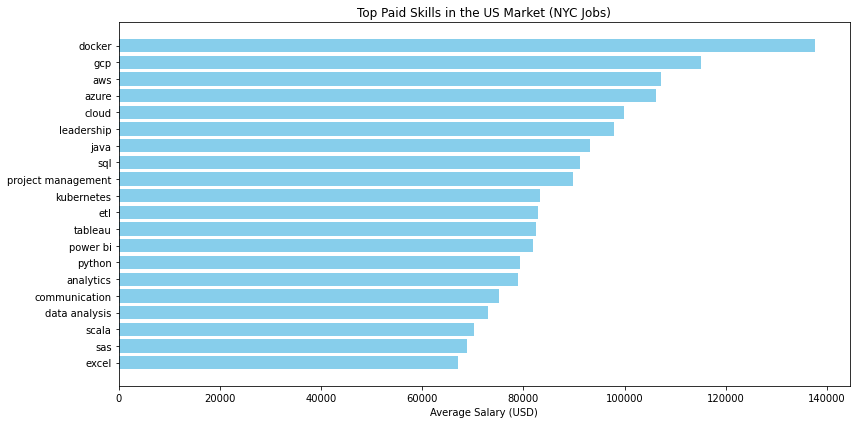

In [89]:
import re
from pyspark.sql.functions import col, avg, explode, udf
from pyspark.sql.types import ArrayType, StringType

# Define a list of known tech/business skills
known_skills = [
    "python", "java", "sql", "excel", "r", "sas", "tableau", "power bi", "spark",
    "aws", "azure", "gcp", "hadoop", "machine learning", "deep learning", "nlp",
    "data science", "data analysis", "etl", "docker", "kubernetes", "project management",
    "leadership", "communication", "statistics", "cloud", "analytics", "nosql", "scala"
]

# Define a cleaner skill extraction UDF
def extract_skills_clean(text):
    if not text:
        return []
    text = text.lower()
    return [skill for skill in known_skills if re.search(r'\b' + re.escape(skill) + r'\b', text)]

extract_skills_udf = udf(extract_skills_clean, ArrayType(StringType()))

# Apply improvements
def highest_paid_skills_perfect(df, top_n=20):
    df = df.withColumn(
        "Average Salary", 
        (col("Salary Range From") + col("Salary Range To")) / 2
    ).filter(
        col("Preferred Skills").isNotNull() & (col("Average Salary") > 10000)
    )

    result = df.withColumn("skills", extract_skills_udf(col("Preferred Skills"))) \
        .withColumn("skill", explode("skills")) \
        .groupBy("skill") \
        .agg(avg("Average Salary").alias("Avg Salary")) \
        .orderBy(col("Avg Salary").desc()) \
        .limit(top_n)

    return result
highest_paid_skills_perfect(processed_df).show(truncate=False)

result_df = highest_paid_skills_perfect(processed_df)
pandas_df = result_df.toPandas()
plt.figure(figsize=(12, 6))
plt.barh(pandas_df["skill"], pandas_df["Avg Salary"], color="skyblue")
plt.xlabel("Average Salary (USD)")
plt.title("Top Paid Skills in the US Market (NYC Jobs)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()